In [1]:
! pip install torchvision torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 189.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 171.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 39.0 MB/s eta 0:00:00


In [2]:
import torchvision
import torch

In [3]:
from torchvision.transforms import v2

def aspect_ratio(img):
    w10 = v2.Resize((20,10), antialias=False)(img)
    w10 = v2.Pad((10, 5, 9, 4))(w10)

    w12 = v2.Resize((20,12), antialias=False)(img)
    w12 = v2.Pad((9, 5, 8, 4))(w12)

    w14 = v2.Resize((20,14), antialias=False)(img)
    w14 = v2.Pad((8, 5, 7, 4))(w14)

    w16 = v2.Resize((20,16), antialias=False)(img)
    w16 = v2.Pad((7, 5, 6, 4))(w16)

    w18 = v2.Resize((20,18), antialias=False)(img)
    w18 = v2.Pad((6, 5, 5, 4))(w18)

    w20 = v2.Pad((5, 5, 4, 4))(img)

    return torch.cat((w10, w12, w14, w16, w18, w20))

transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize((20,20), antialias=False),
    v2.Lambda(aspect_ratio),
    v2.Lambda(lambd=lambda img: img / 255)

])


train_dataset = torchvision.datasets.MNIST("dataset", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST("dataset", train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 144856543.93it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42758804.74it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41912207.19it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6276945.23it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [4]:
x = train_dataset[10][0]
x.shape

torch.Size([6, 29, 29])

In [5]:
from PIL import Image
import numpy as np
from IPython.display import display

def display_img(img):
    x = img.cpu()
    pil_image = Image.fromarray(np.uint8(x.numpy() * 255))
    display(pil_image)

display_img(x[5])

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as v2

class ScaledTanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * F.tanh(x)

class MCDNNSingleFeature(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = DNN()
        self.layer2 = DNN()
        self.layer3 = DNN()
        self.layer4 = DNN()
        self.layer5 = DNN()
    
    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(dim=1)
            
        o1 = self.layer1(x)
        o2 = self.layer2(x)
        o3 = self.layer3(x)
        o4 = self.layer4(x)
        o5 = self.layer5(x)

        return torch.stack([o1, o2, o3, o4, o5], dim=-1)

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4), # (B, 20, 26, 26)
            nn.Tanh(),
            # ScaledTanh(),
            nn.MaxPool2d(2), # (B, 20, 13, 13)
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5), # (B, 40, 9, 9)
            nn.Tanh(),
            # ScaledTanh(),
            nn.MaxPool2d(3), # (B, 40, 3, 3)
            nn.Flatten(start_dim=-3), # (B, 360)
            nn.Linear(in_features=360, out_features=150),
            nn.Tanh(),
            # ScaledTanh(),
            nn.Linear(in_features=150, out_features=10)
        )
        self.rotate = v2.RandomRotation(10)

    # Input is (B, 1, 29, 29)
    def forward(self, x):
        if self.training:
            x = self.rotate(x)
        
        return self.layers(x)

class MCDNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.f0 = MCDNNSingleFeature()
        self.f1 = MCDNNSingleFeature()
        self.f2 = MCDNNSingleFeature()
        self.f3 = MCDNNSingleFeature()
        self.f4 = MCDNNSingleFeature()
        self.f5 = MCDNNSingleFeature()
        
    def forward(self, x):
        o0 = self.f0(x[:, 0, :, :])
        o1 = self.f1(x[:, 1, :, :])
        o2 = self.f2(x[:, 2, :, :])
        o3 = self.f3(x[:, 3, :, :])
        o4 = self.f4(x[:, 4, :, :])
        o5 = self.f5(x[:, 5, :, :])
        
        return torch.cat([o0, o1, o2, o3, o4, o5], dim=-1).mean(dim=-1)

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Using cuda device
NVIDIA GeForce RTX 4090


In [22]:
model = MCDNN().to(device)

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    lossb = []
    for _, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        lossb.append(loss.item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print("loss=", torch.tensor(lossb).mean())
        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [24]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            p = logits.softmax(dim=1)
            correct += (p.argmax(1) == y).type(torch.float).sum().item()
    correct /= size

    return 100*(1-correct)
    # print(f"Test Error: \n Error: {(100*(1-correct)):>0.1f}%")

In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=1)

train_t_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=1)
test_t_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=1)

train_errors = []
test_errors = []
optimizer = torch.optim.SGD(model.parameters(), lr=10**(-0.1))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1, gamma=0.993)
loss_fn = nn.CrossEntropyLoss()
for epoch in range(800):
    print(f"epoch={epoch+1} lr={scheduler.get_last_lr()}")
    train(train_dataloader, model, loss_fn, optimizer)
    scheduler.step()
    
    train_error = test(train_t_dataloader, model)
    train_errors.append(train_error)
    test_error = test(test_t_dataloader, model)
    test_errors.append(test_error)
    print(f"{train_error=} {test_error=}")

epoch=1 lr=[0.7943282347242815]
loss= tensor(1.0564)
train_error=5.541666666666667 test_error=5.069999999999997
epoch=2 lr=[0.7887679370812115]
loss= tensor(0.1647)
train_error=3.2016666666666693 test_error=3.180000000000005
epoch=3 lr=[0.7832465615216431]
loss= tensor(0.1037)
train_error=2.2666666666666613 test_error=2.200000000000002
epoch=4 lr=[0.7777638355909916]
loss= tensor(0.0798)
train_error=1.8249999999999988 test_error=1.6800000000000037
epoch=5 lr=[0.7723194887418546]
loss= tensor(0.0659)
train_error=1.7516666666666625 test_error=1.5700000000000047
epoch=6 lr=[0.7669132523206617]
loss= tensor(0.0568)
train_error=1.2766666666666704 test_error=1.3000000000000012
epoch=7 lr=[0.761544859554417]
loss= tensor(0.0498)
train_error=1.1233333333333317 test_error=1.2199999999999989
epoch=8 lr=[0.756214045537536]
loss= tensor(0.0445)
train_error=1.4499999999999957 test_error=1.3700000000000045
epoch=9 lr=[0.7509205472187732]
loss= tensor(0.0404)
train_error=1.0016666666666674 test_error

KeyboardInterrupt: 

In [15]:
from itertools import islice
from torch.utils.data import DataLoader

model = MCDNN().to(device)
loss_fn = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)

lrei = []
lri = []
lossi = []
for e in torch.linspace(-3, 1, 2000).tolist():
    lr = 10**e
    lrei.append(e)
    lri.append(lr)
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for X, y in islice(train_dataloader, 1):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        lossi.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    print(lrei[-1], lri[-1], lossi[-1])

-3.0 0.001 2.3018605709075928
-2.9979989528656006 0.0010046182125265798 2.302309989929199
-2.995997905731201 0.0010092577529401002 2.2987895011901855
-2.993997097015381 0.001013918163117277 2.3018524646759033
-2.9919960498809814 0.0010186006526791119 2.2999978065490723
-2.989995002746582 0.001023304766972897 2.3045337200164795
-2.9879939556121826 0.00102803060586624 2.3012428283691406
-2.985992908477783 0.001032778269687959 2.300029993057251
-2.983992099761963 0.0010375472896383129 2.302802085876465
-2.9819910526275635 0.0010423389035282395 2.306118965148926
-2.979990005493164 0.001047152646109455 2.299673318862915
-2.9779889583587646 0.001051988619576959 2.3029441833496094
-2.9759879112243652 0.0010568469265977087 2.301522970199585
-2.973987102508545 0.0010617270874466946 2.3032045364379883
-2.9719860553741455 0.00106663036878175 2.3042519092559814
-2.969985008239746 0.0010715562945120883 2.3026227951049805
-2.9679839611053467 0.0010765049692143395 2.303830623626709
-2.965982913970947

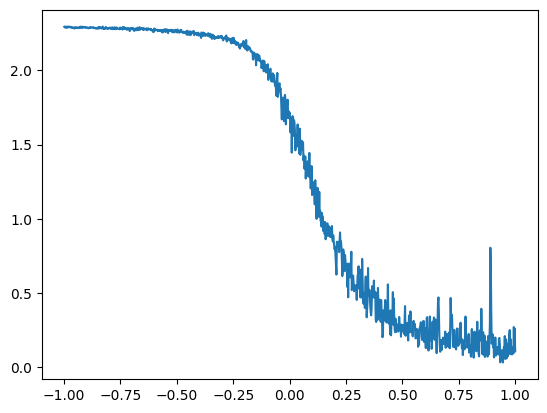

In [21]:
import matplotlib.pyplot as plt

plt.plot(lrei[1000:], lossi[1000:])
plt.show()
# print(lri)